In [1]:
import tensorflow as tf
tf.version.VERSION

'2.16.1'

# Making the TF model

In [ ]:
import tensorflow_datasets as tfds
'rock_paper_scissors' in tfds.list_builders()

In [ ]:
mapper = lambda i: (i['image'], tf.one_hot(i['label'], 3))
train_ds = tfds.load("rock_paper_scissors", split='train', shuffle_files=True).map(mapper)
test_ds = tfds.load("rock_paper_scissors", split='test', shuffle_files=True).map(mapper)

In [ ]:
import ipywidgets as w
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

def display_ds(ds_t, model=None, loss_func=None):
    if model is not None and loss_func is not None:
        x, y = list(zip(*ds_t))
        # print(len(x[0]))
        x = np.array(x)
        y = np.array(y)
        y_ = model.predict(x)
        losses = loss_func(y,y_)
        # print(losses)
        e_ds_t = sorted(enumerate(ds_t), key=lambda i: losses[i[0]])
        e, ds_t = list(zip(*e_ds_t))

    s_t = w.IntSlider(value=1, min=0, max=len(ds_t)-1, layout=w.Layout(width='auto'))
    df = pd.DataFrame({'rock':0.0, 'paper':0.0, 'scissors':0.0}, index=[0])
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
    def on_slider_change(change):
        idx = change['new']
        i = ds_t[idx][0]
        truth = ds_t[idx][1]
        preds = ds_t[idx][1] if model is None else tf.unstack(model(tf.stack([i])))[0]
        loss = None if loss_func is None else loss_func(truth, preds).numpy()
        df.iloc[0] = preds.numpy()
        ax0.clear()
        ax0.imshow(i.numpy())
        pr = ['rock', 'paper', 'scissors'][tf.argmax(preds).numpy()]
        tr = ['rock', 'paper', 'scissors'][tf.argmax(truth).numpy()]
        title = f"Prediction: {pr}\nTruth: {tr}"
        title += "" if loss is None else "\nLoss: "+"%.3g"%loss
        ax0.set_title(title)
        ax1.clear()
        sns.barplot(df, ax=ax1)
        # title = ['rock', 'paper', 'scissors'][tf.argmax(truth).numpy()]
        ax1.set_title(title)
    ax0.set_title("\n\n\n")
    ax1.set_title("\n\n\n")
    fig.tight_layout()

    s_t.observe(on_slider_change, 'value')
    s_t.value=0
    return w.VBox([s_t], layout=w.Layout(width='50%'))

In [ ]:
display_ds(list(train_ds))

In [ ]:
from tensorflow import keras
from keras import layers
IMG_SIZE = 128
class ImageLayers(tf.keras.Model):
    def call(self, input_tensor, training=False):
        img = tf.image.random_hue(input_tensor, 0.08)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        inv = tf.math.multiply(img, -1)
        inv = tf.math.add(inv, 255)
        idx = tf.sign(tf.random.uniform([], -1, 1))/2+0.5
        # idx = 0
        idn = 1-idx
        return tf.math.add(
            tf.math.multiply(img, idx),
            tf.math.multiply(inv, idn)
        )
        # return tf.constant([img, inv])[idx]
data_aug = tf.keras.Sequential([
    # layers.RandomFlip(),
    layers.RandomZoom(height_factor=(0.3, 0.7), width_factor=(0.3,0.5), fill_mode='nearest'),
    layers.RandomRotation(0.5, fill_mode='nearest'),
    layers.RandomFlip(),
    # layers.RandomTranslation(0.4, 0.4, fill_mode='nearest'),
    layers.RandomBrightness(0.05),
    layers.RandomContrast((0.8, 1)),
    ImageLayers()
])
pre_proc = keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])
aug_mapper = lambda i,j: (data_aug(i) , j)
pre_mapper = lambda i,j: (pre_proc(i), j)
display_ds(list(
    train_ds.take(100).map(aug_mapper).map(pre_mapper)#.map(lambda i,j: (tf.cast(tf.image.resize(i, (32,32)), tf.uint8), j))
))
# test_ds.map(lambda i,j: (data_aug(i).as_dtype(tf.uint8), j))

In [ ]:
augmented_ds = train_ds.map(aug_mapper, num_parallel_calls=tf.data.AUTOTUNE).map(pre_mapper, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(128)
unaugmented_ds = train_ds.map(pre_mapper, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(128)
validation_data = test_ds.map(pre_mapper).batch(32)

In [ ]:
import numpy as np
element = unaugmented_ds.take(1).get_single_element()[0]
print(element.shape, np.min(element.numpy()), np.max(element.numpy()))
element = validation_data.take(1).get_single_element()[0]
print(element.shape, np.min(element.numpy()), np.max(element.numpy()))

In [ ]:
from tensorflow import keras
from keras import layers

# @keras.saving.register_keras_serializable()
class AlwaysDropout(layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, True)

model = tf.keras.Sequential(layers= [
    layers.Input((IMG_SIZE, IMG_SIZE,3)),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    # AlwaysDropout(0.25),
    layers.Dense(3, activation='softmax')],
    name = "RPS_recognition_model")
model.summary()

In [ ]:
fitting_ds = augmented_ds
model.compile("adam", tf.keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])
hist = model.fit(
    fitting_ds,
    validation_data=validation_data,
    callbacks=[tf.keras.callbacks.CSVLogger('training.csv'), tf.keras.callbacks.TensorBoard("logdir"), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0)],
    epochs = 100
)

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("training.csv", index_col='epoch')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.lineplot(df[[c for c in df.columns if 'loss' in c]], ax=ax1)
sns.lineplot(df[[c for c in df.columns if 'accuracy' in c]], ax=ax2)
ax2.set_ylim((0,1))
fig.tight_layout()

In [ ]:
display_ds(list(validation_data.unbatch()), model, tf.keras.losses.CategoricalCrossentropy(reduction=None))

In [ ]:
display_ds(list(fitting_ds.unbatch()), model, tf.keras.losses.CategoricalCrossentropy(reduction=None))

In [ ]:
def make_conf_matrix(list_ds):
    x, y = zip(*list_ds)
    x = tf.stack(x)
    y = tf.stack(y)
    y = tf.argmax(y, 1)
    y_ = model.predict(x)
    y_ = tf.argmax(y_, 1)
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_predictions(y, y_, display_labels=['rock','paper', 'scissors'])
make_conf_matrix(list(validation_data.unbatch()))

In [ ]:
len(train_ds), len(test_ds)

In [ ]:
model.save('rps1.keras')

# Using the TF Model

In [2]:
model = tf.keras.models.load_model('rps1.keras')
model.summary()

Model: "RPS_recognition_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,667,019 (151.32 MB)

 Trainable params: 13,222,339 (50.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,444,680 (100.88 MB)

In [16]:
from ipywebrtc import CameraStream, ImageRecorder
camera = CameraStream.facing_user(audio=False)

recorder = ImageRecorder(stream=camera, filename='test')

from PIL import Image
import io
import numpy as np

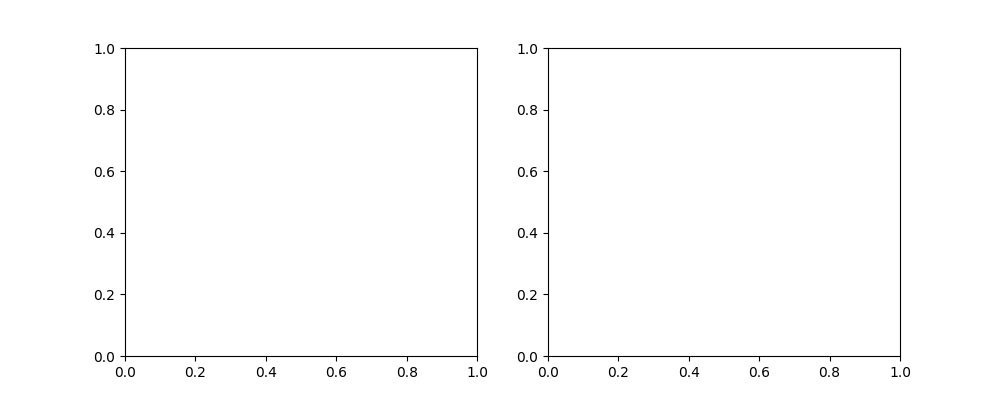

In [17]:
import ipywidgets as w
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
l = w.Label("Hello There")
img_disp = w.Image(format='png')
def pred2():
    time.sleep(0.5)
    img = np.array(Image.open(io.BytesIO(recorder.image.value)).resize((128,128)))[:,:,:3]/255
    ax1.clear()
    ax1.imshow(img)
    pred = model(np.stack([img]))
    df = pd.DataFrame(pred.numpy(), columns=["Rock", "Paper", "Scissors"])
    ax2.clear()
    sns.barplot(df, ax=ax2)
    i = tf.argmax(pred, 1).numpy()[0]
    v = df.columns[i]
    l.value = v
    return v

In [18]:
from threading import Thread
b = w.Button(description='Click to snap picture')
def click(_):
    recorder.recording=True
    Thread(target=pred2).start()
b.on_click(click)
# display(fig)
w.VBox([b, l, camera])